# Challenge 1 - description

To push your classical simulations further, consider using a tensor-network based method (such as Matrix Product States), implemented in iTensor or PastaQ. To time-evolve a quantum state under the dynamics of the Rydberg Hamiltonian, the simplest method is to use "time evolving block decimation" (TEBD). This is the procedure of decomposing the time-evolution operator into a circuit of quantum gates (two-site unitaries) using the Trotter-Suzuki approximation and applying these gates to the tensor network state. See tutorials here.

Implement TEBD using the blockade approximation (see Task 2). Benchmark your tensor network against the results from Bloqade, then repeat for larger 1D arrays. How large can you trust your results using tensor networks? How does this compare with current experimental capabilities? Can you prepare a 2D state of size comparable to current experiments? If tensor networks are state-of-the-art, what do they imply about quantum advantage in Rydberg devices?

# Assumptions

1. We implement a basic 1D TEBD with a numpy.
2. Fixed bond dimension /Chi to simplify the code. But will need to prepare the initial state via imaginary time evolution.
3. Periodic boundary conditions - to simplify dealing with edge MPS matrix contractions
4. We use conventions similar to Kjall et.al. https://arxiv.org/abs/1212.6255

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itebd_functions_finite as tebd_f

# Hyperparameters

In [2]:
chi_max = 20 # maximal bond dimension
delta_t = 0.01 # time step
delta_a_t = 0.05 # adiabatic_time step
N_init_steps = 200 # number of initialization (imaginary time evolution) steps 
N_steps = 300 # number of adiabatic protocol steps 
Nsites = 128 # number of sites
d = 2 # local Hilbert space dimension


In [3]:
# model parameters

Omega = 4. * 2. * np.pi # Rabi frequency
Delta = 2. * np.pi * -10. # on-site potential
rij = 5.72 # distance 
Vint = 2. * np.pi * (862690) / rij**6 # two-site interactions

In [4]:
# pauli matrices

sx = np.array([[0.,1.],[1.,0.]])
sy = np.array([[0.,-1.j],[1.j,0.]])
sz = np.array([[1.,0.],[0.,-1.]])

ni = 1./2. * (np.eye(2) - sz)

# functions for Hamiltonian preparation and evolution operator

def prepare_hamiltonian_op(params):
    
    Ham = params['Vint'] * np.kron(ni, ni) \
        + params['Omega'] * np.kron(sx,np.eye(2)) \
        - params['Delta'] * np.kron(ni, np.eye(2))
    
    return Ham
    

def prepare_evolution_op(Hamiltonian, evolution_type = 'imaginary'):
    '''
    params - dictionary
    evolution type - imaginary or real
    '''
    
    U_evo = []
    
    if evolution_type == 'imaginary':
        d_t = delta_t
    else:
        d_t = 1.j * delta_a_t

    for site in range(0, Nsites):
            
        #construct evolution operator

        w,v = np.linalg.eig(Hamiltonian)
        U_evo.append(np.reshape(np.dot(np.dot(v,np.diag(np.exp(-delta_t*(w)))),np.transpose(v)),(d,d,d,d)))
    
    return U_evo
    


In [5]:
# prepare initial test hamiltonian 

params = {'Omega': Omega, 'Delta': Delta, 'Vint': Vint}

H = prepare_hamiltonian_op(params)

U = prepare_evolution_op(H)

# Representing state via MPS

In [6]:
# prepare MPS site G and bond tensors L (diagonal matrics defined as a vector)

G = np.random.rand(Nsites,d,chi_max,chi_max)+0j;

# diagonal bond tensor
L = np.random.rand(Nsites,chi_max)+0j

# Ground state preparation via system cooling (imaginary time evolution)

In [7]:
# run initializing evolution 

S_list = []
E_list = []
t_list = []
m_list = []
error_list = []

for step in range(1, N_init_steps):
    
    bond_error = []
    
    for site in range(0,Nsites,2):
        error = tebd_f.update_finite(G, L, U, chi_max, site, Nsites)
        bond_error.append(error)
        
    for site in range(1,Nsites,2):
        error = tebd_f.update_finite(G, L, U, chi_max, site, Nsites)
        bond_error.append(error)
    
    t_list.append(step * delta_t)
    
    
    m = tebd_f.site_expectation_value(G, L, ni, Nsites)
    m_list.append(np.abs(m))
    S = tebd_f.entanglement_entropy(L,Nsites)
    S_list.append(np.mean(S))
    E = tebd_f.bond_expectation_value(G,L,np.reshape(H, (d,d,d,d)),Nsites)
    E_list.append(np.real(np.mean((E))))
    
    #print("bond_error", bond_error)
    bond_error = [0 if v is None else v for v in bond_error]
    
    error_list.append(np.mean(bond_error))
    
    print("Energy[",step ,"]=", np.mean(E))

print("Bond energy=",np.mean(E))

Energy[ 1 ]= (25.353612006096732+0j)
Energy[ 2 ]= (11.128879668870274+0j)
Energy[ 3 ]= (-2.1557406750257426+0j)
Energy[ 4 ]= (-6.904094635979057+0j)
Energy[ 5 ]= (-7.810672636745995+0j)
Energy[ 6 ]= (-7.936016355287068+0j)
Energy[ 7 ]= (-7.949452040562151+0j)
Energy[ 8 ]= (-7.950142630905634+0j)
Energy[ 9 ]= (-7.950296102335011+0j)
Energy[ 10 ]= (-7.950877234385162+0j)
Energy[ 11 ]= (-7.951716022805097+0j)
Energy[ 12 ]= (-7.95265991165043+0j)
Energy[ 13 ]= (-7.953631349598143+0j)
Energy[ 14 ]= (-7.9545938259058175+0j)
Energy[ 15 ]= (-7.955529770769095+0j)
Energy[ 16 ]= (-7.956430214841858+0j)
Energy[ 17 ]= (-7.957290276407113+0j)
Energy[ 18 ]= (-7.958107208092582+0j)
Energy[ 19 ]= (-7.958879532112431+0j)
Energy[ 20 ]= (-7.959606634132543+0j)
Energy[ 21 ]= (-7.960288549761261+0j)
Energy[ 22 ]= (-7.960925832148474+0j)
Energy[ 23 ]= (-7.96151945456035+0j)
Energy[ 24 ]= (-7.962070729421443+0j)
Energy[ 25 ]= (-7.962581236870293+0j)
Energy[ 26 ]= (-7.963052760558073+0j)
Energy[ 27 ]= (-7.963

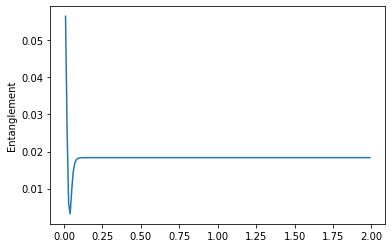

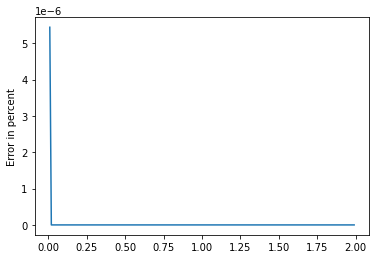

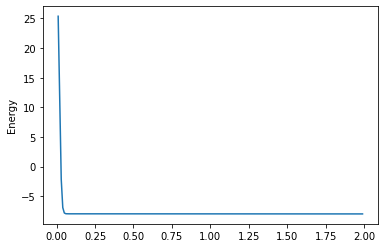

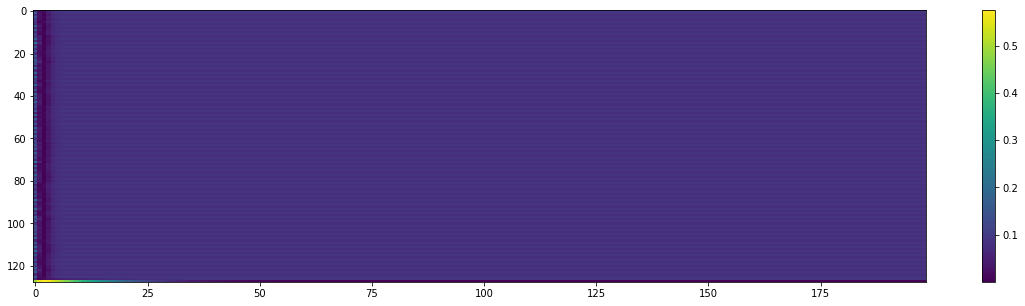

In [8]:
%matplotlib inline

plt.plot(t_list,S_list)
plt.ylabel('Entanglement')
plt.show()

plt.plot(t_list,error_list)
plt.ylabel('Error in percent')
plt.show()

plt.plot(t_list,E_list)
plt.ylabel('Energy')
plt.show()


plt.figure(figsize=(20,5))
plt.imshow(np.array(m_list).transpose(), aspect='auto', interpolation='nearest')
plt.colorbar()

In [9]:
# Define adiabatic evolution protocol

Delta_init = 2. * np.pi * -10. # on-site potential
Delta_max = 2. * np.pi * 10. # on-site potential

Delta_1 = np.linspace(Delta_init, Delta_max, int(N_steps/2))
Delta_2 = np.linspace(Delta_max, Delta_max, int(N_steps/2))
Delta = []
Delta.extend(Delta_1)
Delta.extend(Delta_2)
print(len(Delta))

300


In [12]:
# prepare hamiltonians and evolution operators 

H = []
U = []

for i in range(N_steps):

    params = {'Omega': Omega, 'Delta': Delta[i], 'Vint': Vint}

    H.append(prepare_hamiltonian_op(params))
    
    U.append(prepare_evolution_op(prepare_hamiltonian_op(params), evolution_type='real'))
    


In [13]:
# run initializing evolution 

S_list = []
E_list = []
t_list = []
m_list = []
error_list = []


for step in range(1, N_steps):
    bond_error = []
    for site in range(0,Nsites,2):
        bond_error.append(tebd_f.update_finite(G, L, U[step], chi_max, site, Nsites))
        
    for site in range(1,Nsites,2):
        bond_error.append(tebd_f.update_finite(G, L, U[step], chi_max, site, Nsites))
        
    t_list.append(step * delta_t)
    m = tebd_f.site_expectation_value(G, L, ni, Nsites)
    m_list.append(np.abs(m))
    S = tebd_f.entanglement_entropy(L,Nsites)
    S_list.append(np.mean(S))
    E = tebd_f.bond_expectation_value(G,L,np.reshape(H[step], (d,d,d,d)),Nsites)
    E_list.append(np.real(np.mean((E))))
    
    bond_error = [0 if v is None else v for v in bond_error]
    
    error_list.append(np.mean(bond_error))
    print("Energy[",step ,"]=", np.mean(E))

print("Bond energy=",np.mean(E))

Energy[ 1 ]= (-8.036945799246721+0j)
Energy[ 2 ]= (-8.106533373667224+0j)
Energy[ 3 ]= (-8.17692861172926+0j)
Energy[ 4 ]= (-8.24823010630471+0j)
Energy[ 5 ]= (-8.320483810415638+0j)
Energy[ 6 ]= (-8.393717328845787+0j)
Energy[ 7 ]= (-8.46795097310708+0j)
Energy[ 8 ]= (-8.543202022043985+0j)
Energy[ 9 ]= (-8.619486495731307+0j)
Energy[ 10 ]= (-8.696819919793125+0j)
Energy[ 11 ]= (-8.775217660149686+0j)
Energy[ 12 ]= (-8.854695070303638+0j)
Energy[ 13 ]= (-8.93526755533604+0j)
Energy[ 14 ]= (-9.016950598285128+0j)
Energy[ 15 ]= (-9.099759769227004+0j)
Energy[ 16 ]= (-9.183710726215258+0j)
Energy[ 17 ]= (-9.268819212255476+0j)
Energy[ 18 ]= (-9.355101050240497+0j)
Energy[ 19 ]= (-9.442572136744474+0j)
Energy[ 20 ]= (-9.531248435098604+0j)
Energy[ 21 ]= (-9.621145967950122+0j)
Energy[ 22 ]= (-9.712280809402102+0j)
Energy[ 23 ]= (-9.804669076782663+0j)
Energy[ 24 ]= (-9.898326922068588+0j)
Energy[ 25 ]= (-9.993270522978163+0j)
Energy[ 26 ]= (-10.08951607374302+0j)
Energy[ 27 ]= (-10.187079

Energy[ 212 ]= (-36.64250820374177+0j)
Energy[ 213 ]= (-36.6426589076638+0j)
Energy[ 214 ]= (-36.64279496238241+0j)
Energy[ 215 ]= (-36.64291787470875+0j)
Energy[ 216 ]= (-36.64302898646951+0j)
Energy[ 217 ]= (-36.64312949355678+0j)
Energy[ 218 ]= (-36.643220462686436+0j)
Energy[ 219 ]= (-36.64330284628216+0j)
Energy[ 220 ]= (-36.643377495602955+0j)
Energy[ 221 ]= (-36.64344517231106+0j)
Energy[ 222 ]= (-36.64350655863846+0j)
Energy[ 223 ]= (-36.64356226629251+0j)
Energy[ 224 ]= (-36.643612844227526+0j)
Energy[ 225 ]= (-36.643658785436955+0j)
Energy[ 226 ]= (-36.64370053294865+0j)
Energy[ 227 ]= (-36.643738485166146+0j)
Energy[ 228 ]= (-36.643773000633075+0j)
Energy[ 229 ]= (-36.643804402266554+0j)
Energy[ 230 ]= (-36.64383298110731+0j)
Energy[ 231 ]= (-36.64385899965758+0j)
Energy[ 232 ]= (-36.64388269484788+0j)
Energy[ 233 ]= (-36.64390428067364+0j)
Energy[ 234 ]= (-36.64392395054543+0j)
Energy[ 235 ]= (-36.64394187938566+0j)
Energy[ 236 ]= (-36.64395822550037+0j)
Energy[ 237 ]= (-36

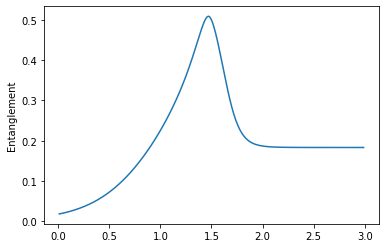

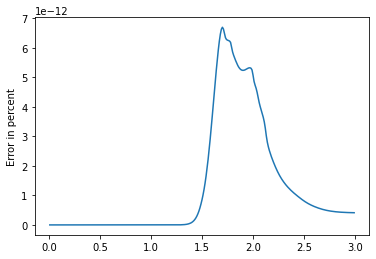

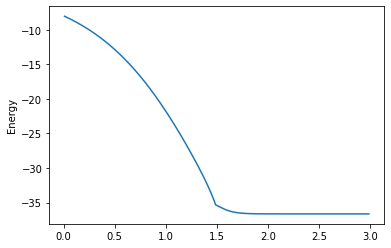

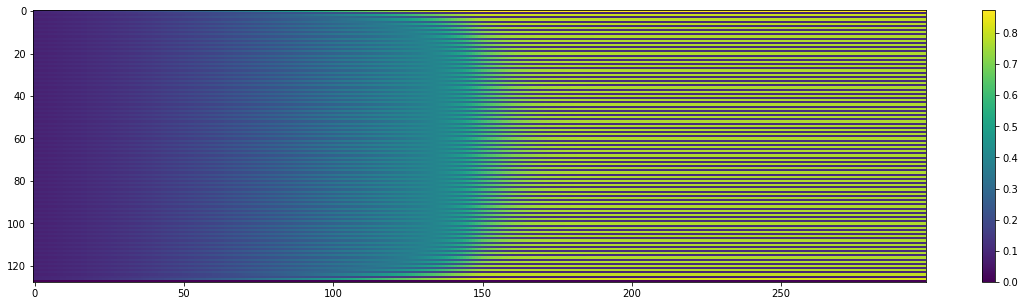

In [14]:
%matplotlib inline

plt.plot(t_list,S_list)
plt.ylabel('Entanglement')
plt.show()


plt.plot(t_list,error_list)
plt.ylabel('Error in percent')
plt.show()

plt.plot(t_list,E_list)
plt.ylabel('Energy')
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(np.array(m_list).transpose(), aspect='auto', interpolation='nearest')
plt.colorbar()

# Conclusions

With TEBD simulations we are able to simulate rather large systems. Here the advantage is in the necessity to consider only low-energy subspace of states which are characterized by low entanglement. Moreover the states of interest are semi-classical.  Hence the bond dimension of our MPS could be very small and we can scale simulations to larger system sizes.

While we did not directly address the 2D systems this is generally a feasible tasks via mapping 2D lattice to a semi-1D chain and applying Swap operators. This will somewhat slow down the computations, but essentially the large enough systems should still be addressable. 